In [2]:

import matplotlib.pyplot as plt
import gpflow
import gpflux
import numpy as np
import ruptures as rpt
import torch
import torch.nn as nn
import torch.nn.functional as F

import tensorflow as tf
from gpflux.helpers import construct_basic_kernel, construct_basic_inducing_variables
from gpflux.layers import GPLayer
from gpflux.experiment_support.plotting import plot_layer
from scipy.optimize import linear_sum_assignment
from ruptures.base import BaseCost
import random
import math
from torch.utils.data import Dataset, DataLoader
from scipy.stats import wasserstein_distance

C:\Users\motsk\anaconda3\envs\thesis\Lib\site-packages\gpflow\versions.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


# Signal/Time Series Construction
## Poisson Point Process
We start by defining an intensity function for the Non-Homogeneous Poisson process (NHPP) and then generate a Point process using a thinning algorithm that can be found here (https://www.columbia.edu/~ks20/4703-Sigman/4703-07-Notes-PP-NSPP.pdf)

In [70]:
def lam(x, a):
    """
    Intensity function for the NHPP
    """
    return a + np.sin(x)

In [71]:
def sample_poisson_jumps(a, lambda_star, length=1000, seed=None):
    """
    Thinning algorithm for generating a poisson point process signal.
    """
    if seed is not None:
        np.random.seed(seed)
    T = 0.01 * length
    t = 0.0
    n = 0
    arrival_times = []
    while True:
        u = np.random.rand()
        t = t - (1/lambda_star) * np.log(u)

        if t > T:
            break
        u = np.random.rand()
        lambda_t = lam(t, a)
        if u <= lambda_t / lambda_star:
            n += 1
            arrival_times.append(t)
    ts = np.linspace(0, T, length)
    ys = np.searchsorted(arrival_times, ts)
    return ts, ys, arrival_times, T

## Deep Gaussian Process (DGP)
We continue with defining the correlated noise of the signals. We start by defining a helper function for sampling layer kernels and hyperparameters. We choose to sample from four stationary kernels supported by GPFlow for each layer and vary their hyperparameters by sampling from the range [0.1, 5]. We then create a set of datapoints that are propagated through a number of predefined layers and save the output of the final layer.

In [72]:
KERNELS = [gpflow.kernels.SquaredExponential,
          gpflow.kernels.Matern12,
          gpflow.kernels.Matern32,
          gpflow.kernels.Matern52]

In [73]:
def randomly_sample_kernels(kernels, num_kernels, seed=None):
    if seed is not None:
        np.random.seed(seed)
    sampled_kernels = []
    for i in range(num_kernels):
        kernel = np.random.choice(kernels)()
        lengthscales = np.random.uniform(0.1, 5.0)
        variance = np.random.uniform(0.1, 5.0)
        kernel.lengthscales.assign(lengthscales)
        kernel.variance.assign(variance)
        sampled_kernels.append(kernel)
    return sampled_kernels

In [74]:
def sample_dgp_signal(datapoints, a, b, samples, kernels, num_layers, seed=None):
    if seed is not None:
        np.random.seed(seed)
        tf.random.set_seed(seed)
    X = np.linspace(a, b, datapoints).reshape(-1, 1)
    Z = X.copy()
    M = Z.shape[0]
    gp_layers = []
    D = 1

    ## Construct the each layer with inducing variables
    for i in range(num_layers):
        ind_var = construct_basic_inducing_variables(M, D, D, share_variables=True, z_init=Z.copy())
        kernel = construct_basic_kernel(
            kernels[i],
            output_dim=D,
            share_hyperparams=True)
        gplayer = GPLayer(kernel, ind_var, datapoints, full_cov=True, num_samples=samples, mean_function=gpflow.mean_functions.Zero())
        gp_layers.append(gplayer)
    samples = []
    layer_input = X
    for layer in gp_layers:
        layer_output = layer(layer_input)

        # sample of shape num_samples, length, 1
        sample = tf.convert_to_tensor(layer_output)
        layer_input = sample[0]
        samples.append(sample.numpy())
        
    return np.squeeze(samples[num_layers-1])

Next is the definition of a batching function for extracting sequences to train the transformer model on. The final output is of dimension [batch_size, seq_len, 1]

In [75]:
def sequence_batch(samples, seq_len, batch_size, device=None):
    
    # Sample ids from each sample
    indexes = torch.randint(0, len(samples), (batch_size,))

    x_batch = []
    y_batch = []
    for i in indexes:
        series = samples[i]
        N = series.shape[0]

        i = torch.randint(0, N - seq_len - 1, (1,)).item()
        
        x = series[i: i + seq_len]
        y = series[i + 1: i + seq_len + 1]

        x_batch.append(x)
        y_batch.append(y)

    x = torch.stack(x_batch).unsqueeze(-1)
    y = torch.stack(y_batch).unsqueeze(-1)
    if device is not None:
        x = x.to(device)
        y = y.to(device)

    return x,y 

We can now define a function that will generate our sequences. The idea is to sample a single baseline poisson point process and then sample multiple noise signals. In the end we get a Tensor of shape [num_samples, length]

In [93]:
def sequences(a, lambda_star, length, kernels, num_layers, num_samples,poisson_seed=None, kernel_seed=None, dgp_seed=None):
    xs, baseline, times, T = sample_poisson_jumps(a, lambda_star, length, poisson_seed)
    kernels = randomly_sample_kernels(kernels, num_layers, kernel_seed)
    samples = baseline[None, :] + sample_dgp_signal(len(xs), 0, T, num_samples, kernels, num_layers, dgp_seed)
    split = int(0.8 * len(samples))
    samples = torch.tensor(
        samples,
        dtype=torch.float32
    )
    print("Data generation completed")
    return baseline, samples[:split], samples[split:]

In [28]:
class DatasetBuilder(Dataset):
    def __init__(self, samples, seq_len, stride=None, mode = 'deterministic'):
        self.samples = samples
        # seq_len here will give us windows
        self.seq_len = seq_len
        self.windows = []
        self.compute_valid_windows()

    def compute_valid_windows(self):
        num_samples, length = self.samples.shape

        for sample_idx in range(num_samples):
            start = 0
            while start + self.seq_len <= length:
                self.windows.append((sample_idx, start))
                start += self.seq_len

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        sample_idx, start = self.windows[idx]

        window = self.samples[sample_idx, start : start + self.seq_len]
        # [window_length, 1]
        x = window[:-1].unsqueeze(-1) 
        y = window[1:].unsqueeze(-1)   

        return x, y

In [114]:
class DatasetBuilder(Dataset):
    def __init__(self, samples, enc_len, dec_len, stride=None):
        self.samples = samples
        self.enc_len = enc_len
        self.dec_len = dec_len
        self.stride = stride if stride is not None else enc_len + dec_len
        self.total_len = enc_len + dec_len
        self.windows = []
        self.compute_valid_windows()
        
    def compute_valid_windows(self):
        num_samples, length = self.samples.shape
        for sample_idx in range(num_samples):
            start = 0
            while start + self.total_len <= length:
                self.windows.append((sample_idx, start))
                start += self.stride
                
    def __len__(self):
        return len(self.windows)
    
    def __getitem__(self, idx):
        sample_idx, start = self.windows[idx]
        
        
        enc_end = start + self.enc_len
        dec_end = enc_end + self.dec_len
        
        # [enc_len, 1]
        x_enc = self.samples[sample_idx, start:enc_end].unsqueeze(-1)
        
        # [dec_len, 1]
        x_dec = self.samples[sample_idx, enc_end-1:dec_end-1].unsqueeze(-1)
        
        # [dec_len, 1]
        y = self.samples[sample_idx, enc_end:dec_end].unsqueeze(-1)
        
        return x_enc, x_dec, y

In [115]:
samples = torch.arange(20).float().reshape(2, 10)  # shape [2, 10]

# 2. Define encoder and decoder lengths
enc_len = 5
dec_len = 5
stride = None

# 3. Instantiate DatasetBuilder
dataset = DatasetBuilder(samples, 5, 5, stride=stride)

# 4. Check length of dataset
print("Number of windows:", len(dataset))

# 5. Inspect the first few windows
for i in range(len(dataset)):
    x_enc, x_dec_start, y = dataset[i]
    print(f"\nWindow {i}:")
    print("x_enc:", x_enc.squeeze(-1).tolist())
    print("x_dec_start:", x_dec_start.squeeze(-1).tolist())
    print("y:", y.squeeze(-1).tolist())

Number of windows: 2

Window 0:
x_enc: [0.0, 1.0, 2.0, 3.0, 4.0]
x_dec_start: [4.0, 5.0, 6.0, 7.0, 8.0]
y: [5.0, 6.0, 7.0, 8.0, 9.0]

Window 1:
x_enc: [10.0, 11.0, 12.0, 13.0, 14.0]
x_dec_start: [14.0, 15.0, 16.0, 17.0, 18.0]
y: [15.0, 16.0, 17.0, 18.0, 19.0]


In [29]:
samples = torch.arange(20).view(2, 10)  # [[0..9], [10..19]]
seq_len = 4

dataset = DatasetBuilder(samples, seq_len)
loader = DataLoader(dataset, batch_size=1, shuffle=False)

print("Number of windows:", len(dataset))
for i, (x, y) in enumerate(loader):
    print(f"\nWindow {i}:")
    print("x:", x.squeeze(-1))
    print("y:", y.squeeze(-1))

Number of windows: 4

Window 0:
x: tensor([[0, 1, 2]])
y: tensor([[1, 2, 3]])

Window 1:
x: tensor([[4, 5, 6]])
y: tensor([[5, 6, 7]])

Window 2:
x: tensor([[10, 11, 12]])
y: tensor([[11, 12, 13]])

Window 3:
x: tensor([[14, 15, 16]])
y: tensor([[15, 16, 17]])


# Transformer
We now define a simple decoder-only Transformer model to be trained on the time series or signal data. This implementation is based on (https://huggingface.co/datasets/bird-of-paradise/transformer-from-scratch-tutorial/tree/main). To be able to adapt the architecture for continuous data, we linearly project the sequence points into the embedding dimension and then use a regression head to get the final output.

In [78]:
# Just some global variables
SEQ_LEN = 50
BATCH_SIZE = 16
D_M = 128
STEPS = 100
device = 'cpu'

In [98]:
class MultiHeadAtt(nn.Module):
    def __init__(self, d_m, n_heads, dropout=0.1, bias=False):
        super().__init__()
        self.d_m = d_m
        self.n_heads = n_heads
        self.d_k = d_m // n_heads

        # Full projections d_m*d_m
        self.W_query = nn.Linear(d_m, d_m, bias=bias)
        self.W_key = nn.Linear(d_m, d_m, bias=bias)
        self.W_value = nn.Linear(d_m, d_m, bias=bias)

        self.W_multi = nn.Linear(d_m, d_m, bias=bias)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, encoder_input=None, mask=None):
        batch_size, sequence_length, d_m = x.shape
        query_matrix = self.W_query(x)

        # Doing cross attention
        if encoder_input is not None:
            encoder_sequence_length = encoder_input.shape[1]
            key_matrix = self.W_key(encoder_input)
            value_matrix = self.W_value(encoder_input)
        else:
            encoder_sequence_length = x.shape[1]
            key_matrix = self.W_key(x)
            value_matrix = self.W_value(x)

        # (B, H, N, D)
        query_heads = query_matrix.view(batch_size, sequence_length, self.n_heads, self.d_k).transpose(1,2)
        key_heads = key_matrix.view(batch_size, encoder_sequence_length, self.n_heads, self.d_k).transpose(1,2)
        value_heads = value_matrix.view(batch_size, encoder_sequence_length, self.n_heads, self.d_k).transpose(1,2)

        # QK^T
        qkt = torch.matmul(query_heads, key_heads.transpose(-1, -2))/ (self.d_k ** 0.5)

        # mask
        #if mask is True:
            #mask = torch.tril(torch.ones(sequence_length, sequence_length, device=x.device)).unsqueeze(0).unsqueeze(0)
            #add_mask = (1.0 - mask) * -1e9
            #qkt = qkt + add_mask
        if mask is not None:
            qkt = qkt + mask
        # Softmax
        att_weights = F.softmax(qkt, dim = -1)
        # Dropout
        att_weights = self.dropout(att_weights)
        # QK^T * V
        attention = torch.matmul(att_weights, value_heads)
        # Concatenate
        output_matrix = attention.transpose(1, 2).contiguous().view(batch_size, sequence_length, d_m)
        output = self.W_multi(output_matrix)

        return output

        

In [99]:
class FeedForward(nn.Module):
    def __init__(self, d_m, d_ff, dropout=0.1):
        super().__init__()
        self.w1 = nn.Linear(d_m, d_ff)
        self.w2 = nn.Linear(d_ff, d_m)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.w1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.w2(x)

        return x

In [100]:
class Encoder(nn.Module):
    def __init__(self, d_m, n_heads, dropout=0.1, bias=False):
        super().__init__()
        self.d_ff = 4*d_m
        self.w = MultiHeadAtt(d_m, n_heads, dropout)
        self.w_norm = nn.LayerNorm(d_m)
        self.ffn = FeedForward(d_m, self.d_ff)
        self.ffn_norm = nn.LayerNorm(d_m)
        self.dropout = nn.Dropout(p = dropout)

    def forward(self, x, padding=None):
        batch_size, seq_len, d_m = x.shape

        # Attention
        x_att = self.w(x, None, padding)
        x_att = self.dropout(x_att)
        x_norm = self.w_norm(x + x_att)

        # FFN
        ffn = self.ffn(x_norm)
        ffn = self.dropout(ffn)
        final = self.ffn_norm(x_norm + ffn)

        return final

In [101]:
class Decoder(nn.Module):
    def __init__(self, d_m, n_heads, dropout=0.1, bias=False):
        super().__init__()
        self.d_m = d_m
        self.d_ff = 4*d_m
        self.attention = MultiHeadAtt(self.d_m, n_heads)
        self.feedforward = FeedForward(self.d_m, self.d_ff)
        self.dropout = nn.Dropout(p=0.1)
        self.layernorm_att = nn.LayerNorm(self.d_m)
        self.layernorm_att2 = nn.LayerNorm(self.d_m)
        self.layernorm_ffn = nn.LayerNorm(self.d_m)

    def create_causal_mask(self, seq_len, x_dec):
        mask = torch.tril(torch.ones(seq_len, seq_len, device=x_dec.device)).unsqueeze(0).unsqueeze(0)
        mask = (1.0 - mask) * -1e9
        return mask
        
    def forward(self, x_dec, x_enc, padding=None):
        seq_len = x_dec.shape[1]
        causal_mask = self.create_causal_mask(seq_len, x_dec)

        # Self Attention
        x_att1 = self.attention(x_dec, None, causal_mask)
        x_att1 = self.dropout(x_att1)
        x_att1 = self.layernorm_att(x_dec + x_att1)

        # Cross Attention
        x_att2 = self.attention(x_att1, x_enc, padding)
        x_att2 = self.dropout(x_att2)
        x_att2 = self.layernorm_att2(x_att1 + x_att2)


        ffn = self.feedforward(x_att2)
        ffn = self.dropout(ffn)
        ffn = self.layernorm_ffn(x_att2 + ffn)
        return ffn
        

In [102]:
class PatchEncodings(nn.Module):
    def __init__(self, d_m, d_input, patch_len, stride=None):
        super().__init__()
        self.patch_len = patch_len
        self.stride = stride if stride else patch_len
        self.d_m = d_m
        self.d_input = d_input


        # Project to d_m
        self.proj = nn.Linear(d_input * patch_len, d_m)

    def forward(self, x):
        batch_size, seq_len, d_input = x.shape
        patch_number = (seq_len - self.patch_len) // self.stride + 1

        patches = x.unfold(dimension=1, size=self.patch_len, step=self.stride)
        patches = patches.reshape(batch_size, patch_number, self.d_input * self.patch_len)

        projections = self.proj(patches)
        return projections
        

In [103]:
class PositionalEncodings(nn.Module):
    def __init__(self, d_m, max_len=2000, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

        pe = torch.zeros(max_len, d_m)

        # pos
        position = torch.arange(0, max_len, dtype = torch.float).unsqueeze(1)

        # i
        indexes = torch.arange(0, d_m,step=2, dtype= torch.float)

        pe[:, 0::2] = torch.sin(position/(torch.tensor(10000) **(indexes/d_m)))
        pe[:, 1::2] = torch.cos(position/(torch.tensor(10000) **(indexes/d_m)))
        #Add batch_size
        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

In [104]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, d_input, d_m, n_heads, n_layers, patch_len, stride=None, max_len=5000, dropout=0.1):
        super().__init__()
        self.d_m = d_m
        self.d_input = d_input
        self.patch_len = patch_len

        # Project time series to embedding dimension
        self.embedding = PatchEncodings(d_m, d_input, patch_len) 

        # Position encodings
        self.pos = PositionalEncodings(d_m)

        encoders = [Encoder(d_m, n_heads, dropout) for i in range(n_layers)]
        self.encoders = nn.ModuleList(encoders)

        decoders = [Decoder(d_m, n_heads, dropout) for i in range(n_layers)]
        self.decoders = nn.ModuleList(decoders)

        self.dropout = nn.Dropout(dropout)
        self.layernorm = nn.LayerNorm(d_m)
        # Project back to get a new patch
        self.output_linear = nn.Linear(d_m, patch_len * d_input)

    def forward(self, x_enc, x_dec, padding=None):

        x_enc = self.embedding(x_enc)
        x_dec = self.embedding(x_dec)

        x_enc = self.pos(x_enc)
        x_dec = self.pos(x_dec)

        x_enc = self.dropout(x_enc)
        x_dec = self.dropout(x_dec)
        for encoder in self.encoders:
            x_enc = encoder(x_enc, padding)
        for decoder in self.decoders:
            x_dec = decoder(x_dec, x_enc, padding)
        x_dec = self.output_linear(x_dec)  # (B, n_patches, patch_len)
        b, s, d = x_dec.shape
        x_dec = x_dec.reshape(b, s*self.patch_len, self.d_input) # (B, seq_len, d_input)
        return x_dec
            
    def generate(self, src, tgt_len, device='cpu', padding=None):
        self.eval()
        with torch.no_grad():
            b = src.size(0)
        
            # Encode source once
            src_patch = self.embedding(src)
            src_patch = self.pos(src_patch)
            for encoder in self.encoders:
                src_patch = encoder(src_patch, padding)
        
            generated = src[:, -self.patch_len:, :].clone()
        
            num_patches = (tgt_len + self.patch_len - 1) // self.patch_len
        
            for i in range(num_patches):
                # Only encode the current sequence
                current_len = min(generated.size(1), tgt_len)
                current_tgt = generated[:, :current_len, :]
            
                # Embed current sequence
                tgt_patches = self.embedding(current_tgt)
                tgt_patches = self.pos(tgt_patches)
            
                for decoder in self.decoders:
                    tgt_patches = decoder(tgt_patches, src_patch, padding)
            
                last = tgt_patches[:, -1:, :]  # (b, 1, d_m)
                next_patch = self.output_linear(last)  # (b, 1, patch_len*d_input)
                next_patch = next_patch.reshape(b, self.patch_len, self.d_input)
            
                generated = torch.cat([generated, next_patch], dim=1)
            
                if generated.size(1) >= self.patch_len + tgt_len:
                    break
    
            return generated[:, self.patch_len:self.patch_len + tgt_len, :]
        

We can now create the training loop for the models

In [108]:
def train(model, train_loader, val_loader, learning_rate=0.001, epochs=10, device='cpu'):
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
    mse = nn.MSELoss()
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        # ---------- Training ----------
        model.train()
        train_loss = 0.0
        for x_enc, x_dec, y in train_loader:
            x_enc = x_enc.to(device)
            x_dec = x_dec.to(device)
            y = y.to(device)
            
            opt.zero_grad()
            output = model(x_enc, x_dec)
            loss = mse(output, y)
            loss.backward()
            opt.step()
            train_loss += loss.item()
            
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # ---------- Validation ----------
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x_enc, x_dec, y in val_loader:
                x_enc = x_enc.to(device)
                x_dec = x_dec.to(device)
                y = y.to(device)
                
                output = model(x_enc, x_dec)
                loss = mse(output, y)
                val_loss += loss.item()
                
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        print(
            f"Epoch {epoch+1}/{epochs} | "
            f"Train: {train_loss:.4f} | "
            f"Val: {val_loss:.4f}"
        )
    
    return train_losses, val_losses, model

Using device: cpu
Generating sine wave data...
Train data shape: torch.Size([800, 512])
Val data shape: torch.Size([100, 512])
Test data shape: torch.Size([100, 512])
Train dataset size: 800
Val dataset size: 100
Test dataset size: 100

Model initialized with 201424 parameters

Starting training...
Epoch 1/50 | Train: 0.1887 | Val: 0.0426
Epoch 2/50 | Train: 0.0449 | Val: 0.0131
Epoch 3/50 | Train: 0.0287 | Val: 0.0044
Epoch 4/50 | Train: 0.0220 | Val: 0.0029
Epoch 5/50 | Train: 0.0184 | Val: 0.0025
Epoch 6/50 | Train: 0.0165 | Val: 0.0026
Epoch 7/50 | Train: 0.0146 | Val: 0.0022
Epoch 8/50 | Train: 0.0131 | Val: 0.0020
Epoch 9/50 | Train: 0.0123 | Val: 0.0020
Epoch 10/50 | Train: 0.0110 | Val: 0.0017
Epoch 11/50 | Train: 0.0103 | Val: 0.0016
Epoch 12/50 | Train: 0.0096 | Val: 0.0017
Epoch 13/50 | Train: 0.0089 | Val: 0.0016
Epoch 14/50 | Train: 0.0085 | Val: 0.0012
Epoch 15/50 | Train: 0.0082 | Val: 0.0020
Epoch 16/50 | Train: 0.0076 | Val: 0.0010
Epoch 17/50 | Train: 0.0071 | Val: 0.

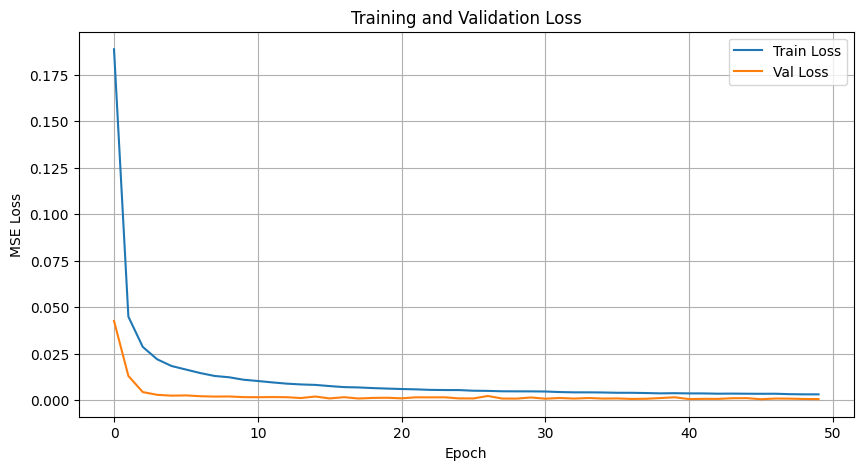


Testing model predictions...


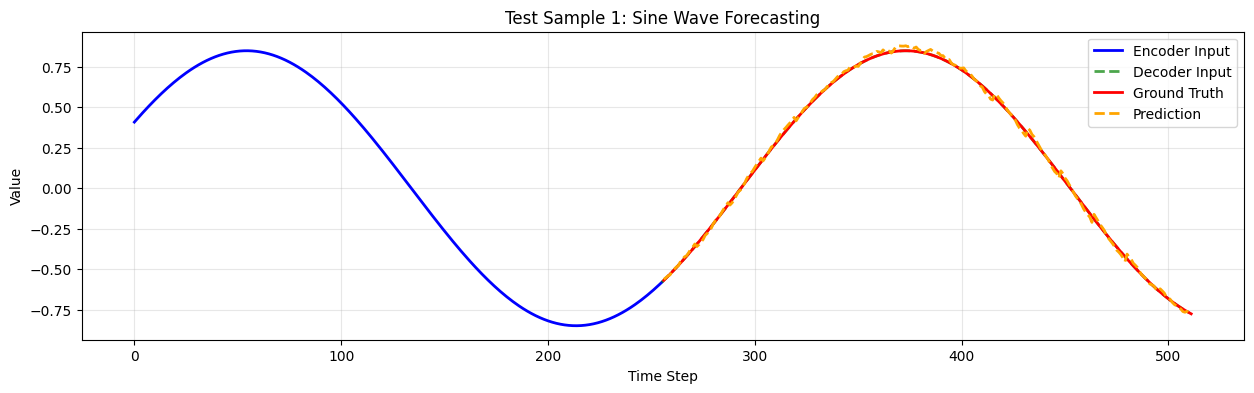

Sample 1 MSE: 0.000267


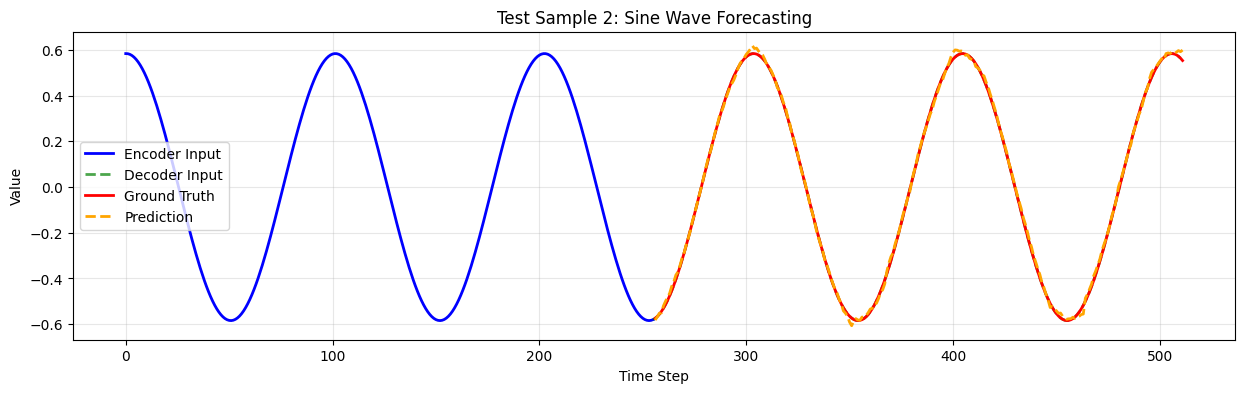

Sample 2 MSE: 0.000131


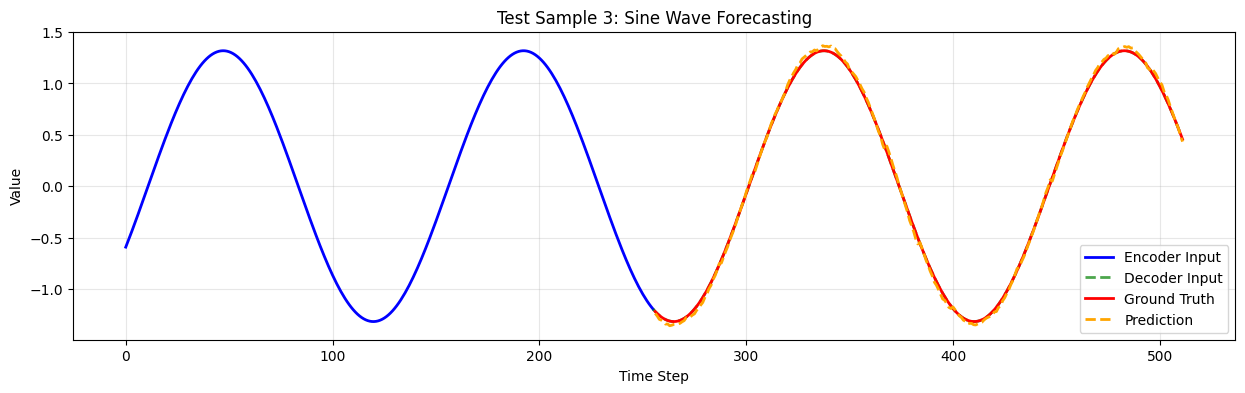

Sample 3 MSE: 0.000841

Testing generation method...


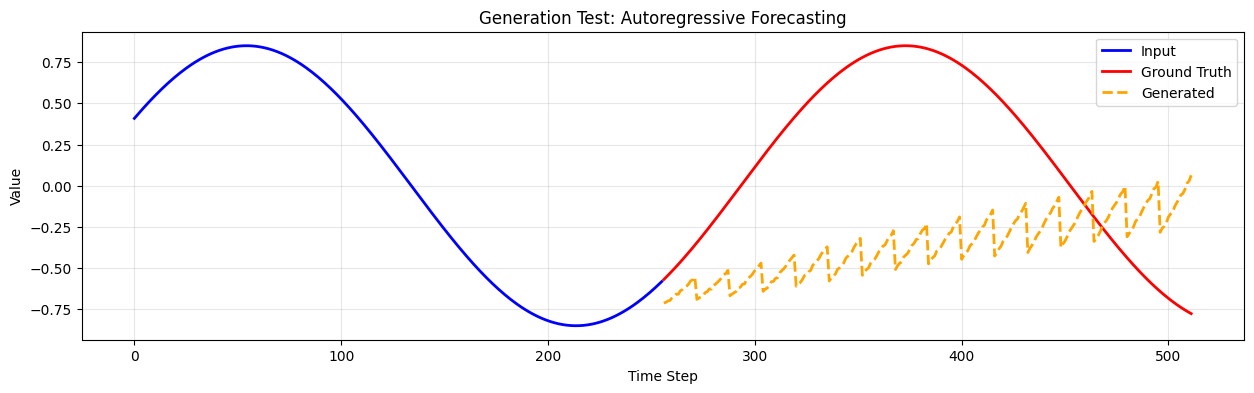

Generation MSE: 0.646222

Testing complete!


In [119]:
device = 'cpu'
print(f"Using device: {device}")

# Generate synthetic sine wave data
def generate_sine_data(n_samples=1000, seq_len=512, freq_range=(0.5, 3.0)):
    """Generate synthetic sine waves with varying frequencies"""
    data = []
    for i in range(n_samples):
        freq = np.random.uniform(freq_range[0], freq_range[1])
        phase = np.random.uniform(0, 2 * np.pi)
        amplitude = np.random.uniform(0.5, 1.5)
        t = np.linspace(0, 4 * np.pi, seq_len)
        sine_wave = amplitude * np.sin(freq * t + phase)
        data.append(sine_wave)
    return torch.tensor(np.array(data), dtype=torch.float32)

# Generate data
print("Generating sine wave data...")
train_data = generate_sine_data(n_samples=800, seq_len=512)
val_data = generate_sine_data(n_samples=100, seq_len=512)
test_data = generate_sine_data(n_samples=100, seq_len=512)

print(f"Train data shape: {train_data.shape}")
print(f"Val data shape: {val_data.shape}")
print(f"Test data shape: {test_data.shape}")

# Create datasets
enc_len = 256
dec_len = 256
patch_len = 16

train_dataset = DatasetBuilder(train_data, enc_len=enc_len, dec_len=dec_len, stride=None)
val_dataset = DatasetBuilder(val_data, enc_len=enc_len, dec_len=dec_len, stride=None)
test_dataset = DatasetBuilder(test_data, enc_len=enc_len, dec_len=dec_len, stride=None)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Val dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model
model = TimeSeriesTransformer(
    d_input=1,
    d_m=64,
    n_heads=4,
    n_layers=2,
    patch_len=patch_len,
    stride=patch_len,
    max_len=5000,
    dropout=0.1
)

print(f"\nModel initialized with {sum(p.numel() for p in model.parameters())} parameters")

# Train the model
print("\nStarting training...")
train_losses, val_losses, trained_model = train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    learning_rate=0.001,
    epochs=50,
    device=device
)

# Plot training curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

# Test the model on a few examples
print("\nTesting model predictions...")
trained_model.eval()
test_samples = 3

with torch.no_grad():
    for i in range(test_samples):
        x_enc, x_dec, y_true = test_dataset[i * 10]
        
        x_enc = x_enc.unsqueeze(0).to(device)
        x_dec = x_dec.unsqueeze(0).to(device)
        
        y_pred = trained_model(x_enc, x_dec)
        
        x_enc = x_enc.cpu().squeeze().numpy()
        x_dec = x_dec.cpu().squeeze().numpy()
        y_true = y_true.squeeze().numpy()
        y_pred = y_pred.cpu().squeeze().numpy()
        
        plt.figure(figsize=(15, 4))
        
        # Plot encoder input
        plt.plot(range(len(x_enc)), x_enc, 'b-', label='Encoder Input', linewidth=2)
        
        # Plot decoder input (overlaps with end of encoder)
        decoder_start = len(x_enc) - 1
        plt.plot(range(decoder_start, decoder_start + len(x_dec)), x_dec, 'g--', 
                 label='Decoder Input', linewidth=2, alpha=0.7)
        
        # Plot ground truth
        plt.plot(range(len(x_enc), len(x_enc) + len(y_true)), y_true, 'r-', 
                 label='Ground Truth', linewidth=2)
        
        # Plot prediction
        plt.plot(range(len(x_enc), len(x_enc) + len(y_pred)), y_pred, 'orange', 
                 label='Prediction', linewidth=2, linestyle='--')
        
        plt.xlabel('Time Step')
        plt.ylabel('Value')
        plt.title(f'Test Sample {i+1}: Sine Wave Forecasting')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.savefig(f'test_sample_{i+1}.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        mse = np.mean((y_true - y_pred) ** 2)
        print(f"Sample {i+1} MSE: {mse:.6f}")

# Test generation capability
print("\nTesting generation method...")
with torch.no_grad():
    x_enc, _, y_true = test_dataset[0]
    x_enc = x_enc.unsqueeze(0).to(device)
    
    # Generate future values
    generated = trained_model.generate(x_enc, tgt_len=dec_len, device=device)
    
    x_enc = x_enc.cpu().squeeze().numpy()
    y_true = y_true.squeeze().numpy()
    generated = generated.cpu().squeeze().numpy()
    
    plt.figure(figsize=(15, 4))
    plt.plot(range(len(x_enc)), x_enc, 'b-', label='Input', linewidth=2)
    plt.plot(range(len(x_enc), len(x_enc) + len(y_true)), y_true, 'r-', 
             label='Ground Truth', linewidth=2)
    plt.plot(range(len(x_enc), len(x_enc) + len(generated)), generated, 'orange', 
             label='Generated', linewidth=2, linestyle='--')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.title('Generation Test: Autoregressive Forecasting')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('generation_test.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    gen_mse = np.mean((y_true - generated) ** 2)
    print(f"Generation MSE: {gen_mse:.6f}")

print("\nTesting complete!")


Testing generation method...


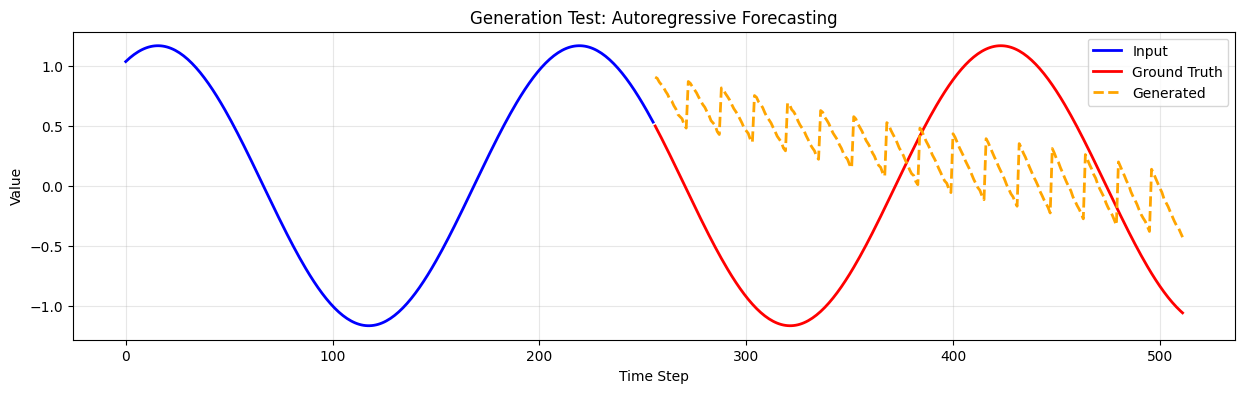

Generation MSE: 0.949205

Testing complete!


In [124]:
print("\nTesting generation method...")
with torch.no_grad():
    x_enc, _, y_true = test_dataset[4]
    x_enc = x_enc.unsqueeze(0).to(device)
    
    # Generate future values
    generated = trained_model.generate(x_enc, tgt_len=dec_len, device=device)
    
    x_enc = x_enc.cpu().squeeze().numpy()
    y_true = y_true.squeeze().numpy()
    generated = generated.cpu().squeeze().numpy()
    
    plt.figure(figsize=(15, 4))
    plt.plot(range(len(x_enc)), x_enc, 'b-', label='Input', linewidth=2)
    plt.plot(range(len(x_enc), len(x_enc) + len(y_true)), y_true, 'r-', 
             label='Ground Truth', linewidth=2)
    plt.plot(range(len(x_enc), len(x_enc) + len(generated)), generated, 'orange', 
             label='Generated', linewidth=2, linestyle='--')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.title('Generation Test: Autoregressive Forecasting')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('generation_test.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    gen_mse = np.mean((y_true - generated) ** 2)
    print(f"Generation MSE: {gen_mse:.6f}")

print("\nTesting complete!")

In [85]:
def generate_sine_wave_sequences(
    n_samples=1000,
    length=300,
    n_waves=3,
    split_ratio=0.8,
    seed=None,
):
    """
    Generate sine-wave time series and split into train / validation sets.

    Returns:
        train_samples: torch.FloatTensor (N_train, length)
        val_samples:   torch.FloatTensor (N_val, length)
    """

    if seed is not None:
        np.random.seed(seed)
        torch.manual_seed(seed)

    samples = np.zeros((n_samples, length), dtype=np.float32)

    for i in range(n_samples):
        freq = np.random.uniform(0.5, 3.0, n_waves)
        phase = np.random.uniform(0, 2 * np.pi, n_waves)
        amp = np.random.uniform(0.5, 1.5, n_waves)

        t = np.linspace(0, 4 * np.pi, length)
        signal = np.zeros(length, dtype=np.float32)

        for f, p, a in zip(freq, phase, amp):
            signal += a * np.sin(f * t + p)

        signal /= n_waves
        samples[i] = signal

    split = int(split_ratio * n_samples)

    train_samples = torch.FloatTensor(samples[:split])
    val_samples   = torch.FloatTensor(samples[split:])

    return train_samples, val_samples

In [86]:
train_samples, val_samples = generate_sine_wave_sequences()

# Build datasets
train_dataset = DatasetBuilder(
    samples=train_samples,
    seq_len=300,
    stride=300,
    mode="deterministic"
)

val_dataset = DatasetBuilder(
    samples=val_samples,
    seq_len=300,
    stride=300,
    mode="deterministic"
)
print(len(val_dataset))
print(len(train_dataset))

# Build dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=True
)

200
800


In [85]:
model = TimeSeriesTransformer(1, D_M, 4, 3)
train_los, val_los, model = train1(model, train_loader, val_loader, epochs=50)
torch.save(model.state_dict(), 'transformer_model.pth')
model.eval()

# pick one validation sample
idx = torch.randint(0, val_samples.shape[0], (1,)).item()
gt_sequence = val_samples[idx].unsqueeze(0).unsqueeze(-1).to(device)  
generated = model.generate(gt_sequence[:, :150,:], 150)
#signal_plot = gt_sequence[:,:50,:].squeeze(0).squeeze(-1).cpu().numpy()
ground_truth = gt_sequence.squeeze(0).squeeze(-1).cpu().numpy()
generated_plot = generated.squeeze(0).squeeze(-1).cpu().numpy()
plt.figure(figsize=(12,4))

plt.plot(ground_truth, label="Ground Truth", linewidth=2)
#plt.plot(generated_plot, label="Generated", linestyle="--")
plt.plot(
    range(150, 150 + len(generated_plot)),
    generated_plot,
    "--",
    label="Generated (future)"
)
plt.axvline(150, color="k", linestyle=":", label="Prediction Start")

plt.legend()
plt.title("Synthetic vs Generated Time Series")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

Epoch 1/50 | Train: 0.0731 | Val: 0.0038
Epoch 2/50 | Train: 0.0085 | Val: 0.0014
Epoch 3/50 | Train: 0.0031 | Val: 0.0014
Epoch 4/50 | Train: 0.0025 | Val: 0.0010
Epoch 5/50 | Train: 0.0023 | Val: 0.0010
Epoch 6/50 | Train: 0.0022 | Val: 0.0013
Epoch 7/50 | Train: 0.0020 | Val: 0.0011
Epoch 8/50 | Train: 0.0020 | Val: 0.0011
Epoch 9/50 | Train: 0.0019 | Val: 0.0011
Epoch 10/50 | Train: 0.0019 | Val: 0.0011
Epoch 11/50 | Train: 0.0018 | Val: 0.0011
Epoch 12/50 | Train: 0.0018 | Val: 0.0013
Epoch 13/50 | Train: 0.0017 | Val: 0.0012
Epoch 14/50 | Train: 0.0017 | Val: 0.0014
Epoch 15/50 | Train: 0.0017 | Val: 0.0015
Epoch 16/50 | Train: 0.0017 | Val: 0.0013
Epoch 17/50 | Train: 0.0015 | Val: 0.0017
Epoch 18/50 | Train: 0.0015 | Val: 0.0015
Epoch 19/50 | Train: 0.0015 | Val: 0.0015
Epoch 20/50 | Train: 0.0015 | Val: 0.0015
Epoch 21/50 | Train: 0.0014 | Val: 0.0013
Epoch 22/50 | Train: 0.0014 | Val: 0.0017
Epoch 23/50 | Train: 0.0014 | Val: 0.0014
Epoch 24/50 | Train: 0.0013 | Val: 0.0017
E

KeyboardInterrupt: 

In [17]:
def sequence_batch(samples, seq_len, batch_size, device=None):
    #processing = []
    #for sample in samples:
        #processing.append(torch.tensor(sample, dtype=torch.float32))
    
    # Sample ids from each sample
    indexes = torch.randint(0, len(samples), (batch_size,))

    x_batch = []
    y_batch = []
    for i in indexes:
        series = samples[i]
        N = series.shape[0]

        i = torch.randint(0, N - seq_len - 1, (1,)).item()
        
        x = series[i: i + seq_len]
        y = series[i + 1: i + seq_len + 1]

        x_batch.append(x)
        y_batch.append(y)

    x = torch.stack(x_batch).unsqueeze(-1)
    y = torch.stack(y_batch).unsqueeze(-1)
    if device is not None:
        x = x.to(device)
        y = y.to(device)

    return x,y 

In [55]:
def train(model, train_samples, val_samples, learning_rate=0.001, steps=10000, seed=None):
    model = model.to(device)

    opt = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    sc = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=steps)
    mse = nn.MSELoss()

    train_losses = []
    val_losses = []

    val_interval = 100  # Validate every 100 steps

    for step in range(steps):
        # --- Training ---
        model.train()
        x_train, y_train = sequence_batch(train_samples, 50, BATCH_SIZE, device=device)
        opt.zero_grad()
        output = model(x_train)
        loss = mse(output, y_train)
        loss.backward()
        opt.step()
        sc.step()
        train_losses.append(loss.item())

        # --- Periodic Validation ---
        if (step + 1) % val_interval == 0 or step == 0:
            model.eval()
            with torch.no_grad():
                x_val, y_val = sequence_batch(val_samples, 50, BATCH_SIZE, device=device)
                val_loss = mse(model(x_val), y_val).item()
            val_losses.append((step + 1, val_loss))
            print(f'Step {step+1}/{steps} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss:.4f}')

    return train_losses, val_losses, model

Step 1/5000 | Train Loss: 1.1692 | Val Loss: 0.6687
Step 100/5000 | Train Loss: 0.0206 | Val Loss: 0.0197
Step 200/5000 | Train Loss: 0.0201 | Val Loss: 0.0200
Step 300/5000 | Train Loss: 0.0185 | Val Loss: 0.0197
Step 400/5000 | Train Loss: 0.0181 | Val Loss: 0.0236
Step 500/5000 | Train Loss: 0.0181 | Val Loss: 0.0236
Step 600/5000 | Train Loss: 0.0181 | Val Loss: 0.0136
Step 700/5000 | Train Loss: 0.0178 | Val Loss: 0.0155
Step 800/5000 | Train Loss: 0.0161 | Val Loss: 0.0181
Step 900/5000 | Train Loss: 0.0150 | Val Loss: 0.0145
Step 1000/5000 | Train Loss: 0.0154 | Val Loss: 0.0157
Step 1100/5000 | Train Loss: 0.0158 | Val Loss: 0.0143
Step 1200/5000 | Train Loss: 0.0168 | Val Loss: 0.0155
Step 1300/5000 | Train Loss: 0.0139 | Val Loss: 0.0134
Step 1400/5000 | Train Loss: 0.0171 | Val Loss: 0.0161
Step 1500/5000 | Train Loss: 0.0154 | Val Loss: 0.0150
Step 1600/5000 | Train Loss: 0.0156 | Val Loss: 0.0129
Step 1700/5000 | Train Loss: 0.0130 | Val Loss: 0.0142
Step 1800/5000 | Train

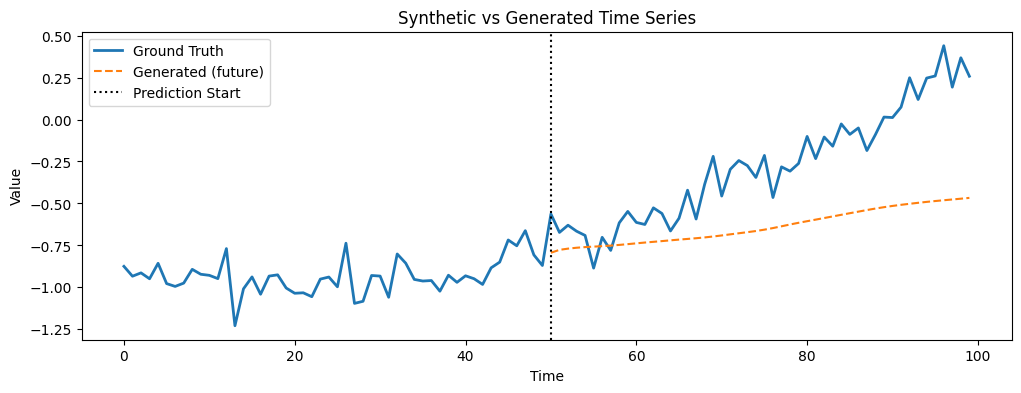

In [21]:
def generate_synthetic_data(n_samples=1000, length=100):
    t = np.linspace(0, 5, length)
    data = []
    for _ in range(n_samples):
        phase = np.random.rand() * 2*np.pi
        freq = np.random.rand() * 0.5 + 0.1
        signal = np.sin(freq * t + phase) + 0.1*np.random.randn(length)
        data.append(signal)
    return data

samples = generate_synthetic_data(n_samples=1000, length=100)
processing = []
for sample in samples:
    processing.append(torch.tensor(sample, dtype=torch.float32))
n_train = int(0.8 * len(processing)) 
train_samples = processing[:n_train]
val_samples = processing[n_train:]
model = TimeSeriesTransformer(1, D_M, 4, 3)
train_los, val_los, model = train(model, train_samples, val_samples)
model.eval()
signal = random.choice(val_samples)
signal = signal.unsqueeze(0).unsqueeze(-1)
generated = model.generate(signal[:, :50,:], 50)
signal_plot = signal.squeeze(0).squeeze(-1).cpu().numpy()
generated_plot = generated.squeeze(0).squeeze(-1).cpu().numpy()
plt.figure(figsize=(12,4))

plt.plot(signal_plot, label="Ground Truth", linewidth=2)
plt.plot(
    range(50, 50 + len(generated_plot)),
    generated_plot,
    "--",
    label="Generated (future)"
)
plt.axvline(50, color="k", linestyle=":", label="Prediction Start")

plt.legend()
plt.title("Synthetic vs Generated Time Series")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

In [87]:
def sequences(a, lambda_star, length, kernels, num_layers, num_samples,poisson_seed=None, kernel_seed=None, dgp_seed=None):
    xs, baseline, times, T = sample_poisson_jumps(a, lambda_star, length, poisson_seed)
    kernels = randomly_sample_kernels(kernels, num_layers, kernel_seed)
    samples = []
    for i in range(num_samples):
        samples.append(baseline + np.squeeze(sample_dgp_signal(len(xs), 0, T, 1, kernels, num_layers, dgp_seed)))
    split = int(0.8 * len(samples))
    samples = torch.tensor(
        np.stack(samples, axis=0),
        dtype=torch.float32
    )
    print("Data generation completed")
    return samples[:split], samples[split:]

In [96]:
baseline, train_data, val_data = sequences(2, 3, 100, KERNELS, 1, 1000, poisson_seed=1, kernel_seed=1)

Data generation completed


In [93]:
train_data_norm = (train_data - mean) / std
val_data_norm   = (val_data - mean) / std

In [99]:

train_dataset = DatasetBuilder(
    samples=train_data,
    seq_len=50,
    stride=100,
    mode="deterministic"
)

val_dataset = DatasetBuilder(
    samples=val_data,
    seq_len=50,
    stride=100,
    mode="deterministic"
)
print(len(val_dataset))
print(len(train_dataset))

# Build dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=True
)

200
800


In [90]:
plt.plot(train_data[0])

IndexError: index 0 is out of bounds for dimension 0 with size 0

In [100]:
model = TimeSeriesTransformer(1, D_M, 4, 3)
train_los, val_los, model = train1(model, train_loader, val_loader, epochs=50)

Epoch 1/50 | Train: 0.8961 | Val: 0.1666
Epoch 2/50 | Train: 0.1460 | Val: 0.0604
Epoch 3/50 | Train: 0.0910 | Val: 0.0491
Epoch 4/50 | Train: 0.0756 | Val: 0.0428
Epoch 5/50 | Train: 0.0670 | Val: 0.0407
Epoch 6/50 | Train: 0.0618 | Val: 0.0440
Epoch 7/50 | Train: 0.0591 | Val: 0.0441
Epoch 8/50 | Train: 0.0567 | Val: 0.0405
Epoch 9/50 | Train: 0.0544 | Val: 0.0467
Epoch 10/50 | Train: 0.0546 | Val: 0.0442
Epoch 11/50 | Train: 0.0525 | Val: 0.0408
Epoch 12/50 | Train: 0.0510 | Val: 0.0516
Epoch 13/50 | Train: 0.0510 | Val: 0.0452
Epoch 14/50 | Train: 0.0505 | Val: 0.0461
Epoch 15/50 | Train: 0.0490 | Val: 0.0441
Epoch 16/50 | Train: 0.0502 | Val: 0.0466
Epoch 17/50 | Train: 0.0480 | Val: 0.0487
Epoch 18/50 | Train: 0.0481 | Val: 0.0475
Epoch 19/50 | Train: 0.0479 | Val: 0.0548
Epoch 20/50 | Train: 0.0495 | Val: 0.0457
Epoch 21/50 | Train: 0.0474 | Val: 0.0465
Epoch 22/50 | Train: 0.0492 | Val: 0.0591
Epoch 23/50 | Train: 0.0475 | Val: 0.0485
Epoch 24/50 | Train: 0.0480 | Val: 0.0459
E

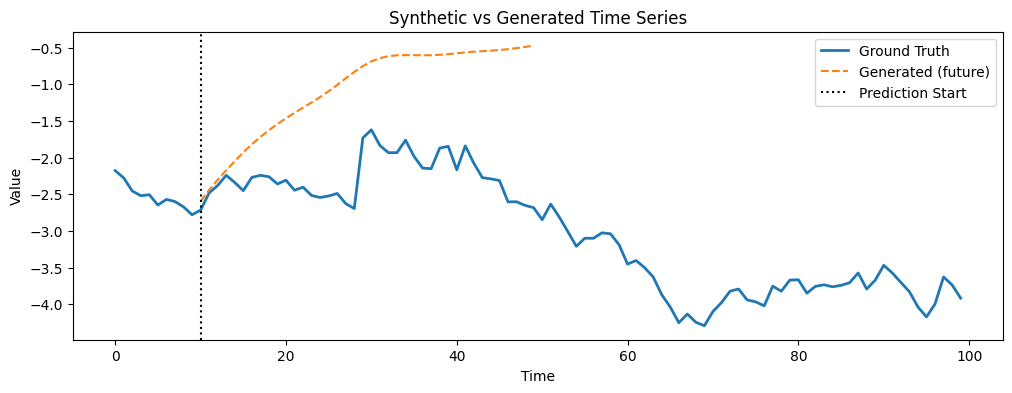

In [105]:

model.eval()
signal = random.choice(val_data)
signal = signal.unsqueeze(0).unsqueeze(-1)
generated = model.generate(signal[:, :10,:], 40)
signal_plot = signal.squeeze(0).squeeze(-1).cpu().numpy()
generated_plot = generated.squeeze(0).squeeze(-1).cpu().numpy()
plt.figure(figsize=(12,4))

plt.plot(signal_plot, label="Ground Truth", linewidth=2)
plt.plot(
    range(10, 10 + len(generated_plot)),
    generated_plot,
    "--",
    label="Generated (future)"
)
plt.axvline(10, color="k", linestyle=":", label="Prediction Start")

plt.legend()
plt.title("Synthetic vs Generated Time Series")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

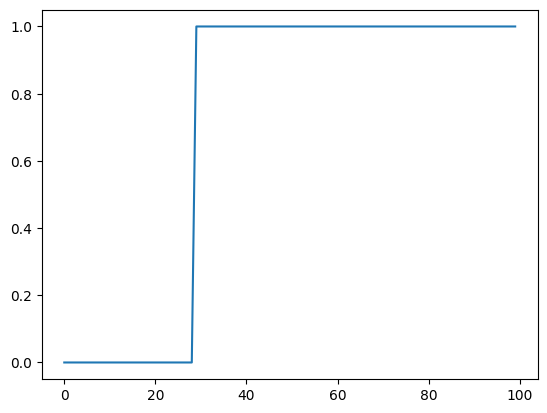

In [160]:
ts,ys,times,T = sample_poisson_jumps(2,3,100,1)
plt.plot(ys)

## Estimation

We can extract meaningful statistics from each signal using a changepoint estimator.


In [115]:
def estimate_cp(signal, pen):
    return rpt.Pelt(model='l2').fit(signal).predict(pen=pen)

In [116]:
def extract_signal_statistics(ys):
    # First, estimate the changepoints
    cps = estimate_cp(ys, 5)
    cps = np.asarray(cps, dtype=int)
    T = len(ys)
    
    # Get the boundaries of each changepoint
    boundaries = np.concatenate(([0], cps))
    # 1) We calculate the length of the regime change 
    inter_arrivals = np.diff(boundaries)

    # 2) We calculate the rate of changepoints and their number
    cp_rate = len(cps)/T
    num_cps = len(cps)

    means = []
    variances = []
    lengths = inter_arrivals
    segments = [(boundaries[i],boundaries[i+1]) for i in range(len(boundaries)-1)]
    for (start, end) in segments:
        segment = ys[start:end]
        means.append((segment.mean() - ys.mean()) / ys.std())
        variances.append(segment.var())
    # 3) Local statistics, means, variances and lengths
    means = np.asarray(means)
    variances = np.asarray(variances)

    # 4) Jumps in means
    jumps = np.diff(means)

    # 5) correlation of lengths, everything but the last vs everything but the first
    length_corr = (
        np.corrcoef(lengths[:-1], lengths[1:])[0, 1]
        if len(lengths) > 2 else np.nan
    )

    jump_length_corr = (
        np.corrcoef(np.abs(jumps), lengths[1:])[0, 1]
        if len(jumps) > 1 else np.nan
    )

    statistics =  {
        "cps" : cps,
        "num_cps" : num_cps,
        "cp_rate": cp_rate,
        "inter_arrivals": inter_arrivals,
        "lengths": lengths,
        "means": means,
        "variances": variances,
        "jumps": jumps,
        "length_corr": length_corr,
        "jump_length_corr": jump_length_corr,
        }
    return statistics
    

In [156]:
value_dict = extract_signal_statistics(generated_plot)

In [157]:
for i in value_dict['cps']:
    print(i)

40


In [158]:
value_dict = extract_signal_statistics(signal_plot)
value_dict['cps']

array([ 30, 100])

In [142]:
baseline, train_data, val_data = sequences(2, 3, 1000, KERNELS, 1, 10, poisson_seed=1, kernel_seed=42)

Data generation completed


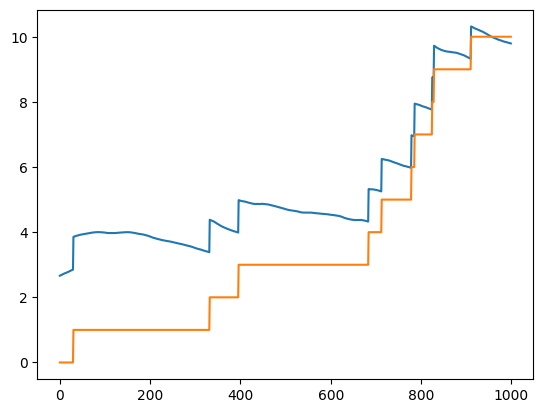

In [143]:
plt.plot(train_data[1])
plt.plot(baseline)

In [144]:
mean = train_data.mean()
std  = train_data.std(unbiased=False) + 1e-8
train_data_norm = (train_data - mean) / std
val_data_norm   = (val_data - mean) / std

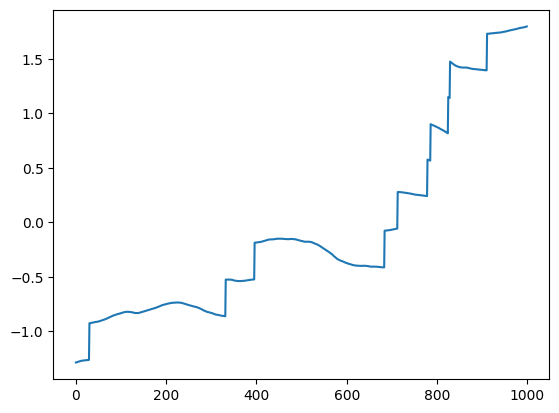

In [145]:
plt.plot(train_data_norm[0])

In [146]:
value_dict = extract_signal_statistics(train_data[0])
value_dict1 = extract_signal_statistics(train_data_norm[0])

print(value_dict['cps'])
print(value_dict1['cps'])

[  30  330  395  565  685  715  780  825  910 1000]
[  30  395  710  780  825  910 1000]


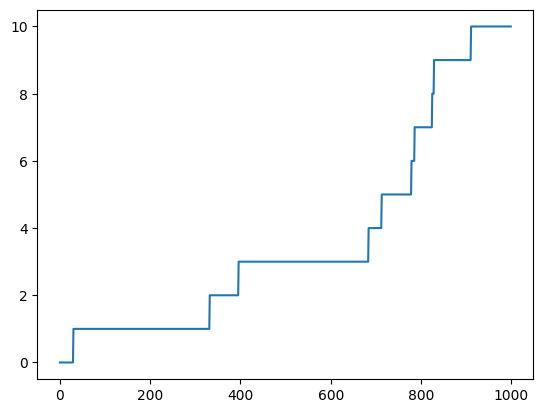

In [130]:
ts,ys,times,T = sample_poisson_jumps(2,3,1000,1)
plt.plot(ys)